Búsqueda y exploración de hiperparámetros
=========================================

## Introducción

El ajuste de hiperparámetros, es decir el proceso que busca optimizar los valores de los parámetros para obtener una buena solución, generalmente requiere una gran cantidad de ejecuciones del algoritmo para analizar su rendimiento en una instancia con diferentes configuraciones de parámetros.

En este ejemplo, veremos como probar varias configuraciones de hiperparámetros y compararlas:

## Entrenando y optimizando parámetros para el problema censo de la UCI

### Instalación

In [1]:
!wget https://raw.githubusercontent.com/santiagxf/E72102/master/docs/develop/modeling/experimentation/code/tuning_bayesian.txt \
    --quiet --no-clobber
!pip install -r tuning_bayesian.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 1.0 MB/s eta 0:00:00


In [30]:
%pip install sklearn_evaluation --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.8 MB/s eta 0:00:00


### Sobre el conjunto de datos del censo UCI

El conjunto de datos del censo de la UCI es un conjunto de datos en el que cada registro representa a una persona. Cada registro contiene 14 columnas que describen a una una sola persona, de la base de datos del censo de Estados Unidos de 1994. Esto incluye información como la edad, el estado civil y el nivel educativo. La tarea es determinar si una persona tiene un ingreso alto (definido como ganar más de $50 mil al año). Esta tarea, dado el tipo de datos que utiliza, se usa a menudo en el estudio de equidad, en parte debido a los atributos comprensibles del conjunto de datos, incluidos algunos que contienen tipos sensibles como la edad y el género, y en parte también porque comprende una tarea claramente del mundo real.

Descargamos el conjunto de datos

In [2]:
!wget https://santiagxf.blob.core.windows.net/public/datasets/uci_census.zip \
    --quiet --no-clobber
!mkdir -p datasets/uci_census
!unzip -qq uci_census.zip -d datasets/uci_census

Lo importamos

In [3]:
import pandas as pd
import numpy as np

train = pd.read_csv('datasets/uci_census/data/adult-train.csv')
test = pd.read_csv('datasets/uci_census/data/adult-test.csv')

### Creando un modelo base para luego ajustar

Preparando nuestros conjuntos de datos

In [4]:
X_train = train.drop(['income'], axis=1)
y_train = train['income'].to_numpy()
X_test = test.drop(['income'], axis=1)
y_test = test['income'].to_numpy()

In [5]:
classes = train['income'].unique().tolist()
features = X_train.columns.values.tolist()
categorical_features = X_train.dtypes[X_train.dtypes == 'object'].index.tolist()

Realizaremos un pequeño preprocesamiento antes de entrenar el modelo:

- Imputaremos los valores faltantes de las caracteristicas numéricas con la media
- Imputaremos los valores faltantes de las caracteristicas categóricas con el valor `?`
- Escalaremos los valores numericos utilizando un `StandardScaler`
- Codificaremos las variables categóricas utilizando `OneHotEncoder`

In [6]:
from typing import Tuple, List

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


def prepare(X: pd.DataFrame) -> Tuple[np.ndarray, sklearn.compose.ColumnTransformer]:
    pipe_cfg = {
        'num_cols': X.dtypes[X.dtypes == 'int64'].index.values.tolist(),
        'cat_cols': X.dtypes[X.dtypes == 'object'].index.values.tolist(),
    }

    num_pipe = Pipeline([
        ('num_imputer', SimpleImputer(strategy='median')),
        ('num_scaler', StandardScaler())
    ])

    cat_pipe = Pipeline([
        ('cat_imputer', SimpleImputer(strategy='constant', fill_value='?')),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    transformations = ColumnTransformer([
        ('num_pipe', num_pipe, pipe_cfg['num_cols']),
        ('cat_pipe', cat_pipe, pipe_cfg['cat_cols'])
    ])
    X = transformations.fit_transform(X)

    return X, transformations


X_train_transformed, transformations = prepare(X_train)
X_test_transformed = transformations.transform(X_test)

Codifiquemos la variable a predecir:

In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y_train)

y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

Nuestro modelo estará basado en un XGBoost:

In [8]:
from xgboost.sklearn import XGBClassifier

base_model = XGBClassifier(objective='binary:logistic', nthread=4)

### Explorando diferentes combinaciones de hiperparámetros con búsqueda exhaustiva

In [9]:
parameters = {
    'learning_rate': [.03, 0.05, .07, 0.5],
    'max_depth': [3, 5, 7, 9, 20],
    'min_child_weight': [4],
    'alpha': [0, 0.5, 1],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.7],
    'n_estimators': [200]
}

In [12]:
from sklearn.model_selection import GridSearchCV

In [13]:
gs = GridSearchCV(
    estimator=base_model,
    param_grid=parameters,
    cv=2,
    n_jobs=-1,
    verbose=2
)

best_model = gs.fit(X_train_transformed, y_train)

Fitting 2 folds for each of 180 candidates, totalling 360 fits
[22:59:27] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



Ejecutamos el modelo

In [14]:
predictions = best_model.predict(X_test_transformed)

Podemos revisar la performance del modelo:

In [15]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     12435
           1       0.78      0.66      0.71      3846

    accuracy                           0.88     16281
   macro avg       0.84      0.80      0.82     16281
weighted avg       0.87      0.88      0.87     16281



Podemos inspeccionar cuales son los mejores parametros que se encontraron:

In [17]:
best_model.best_params_

{'alpha': 1,
 'colsample_bytree': 0.7,
 'learning_rate': 0.07,
 'max_depth': 7,
 'min_child_weight': 4,
 'n_estimators': 200,
 'subsample': 1}

La libraria `sklearn_evaluation` nos permite revisar esto un poco más en detalle. Podemos ver el error por ejemplo en alguna sección de los parámetros que se exploraron:

<Axes: >

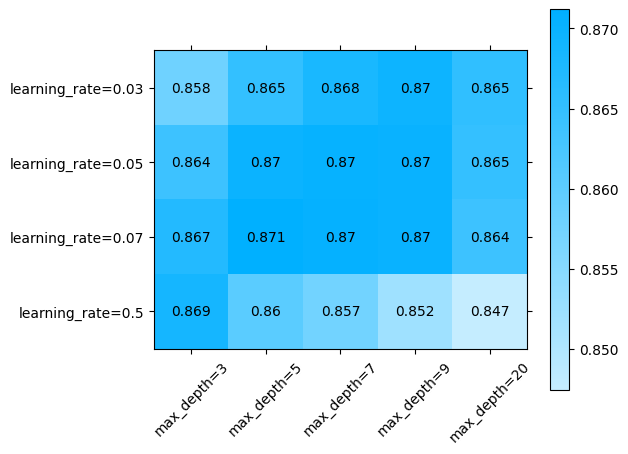

In [31]:
import sklearn_evaluation

sklearn_evaluation.plot.grid_search(
    best_model.cv_results_,
    change=('learning_rate', 'max_depth'),
    subset={ 'subsample': [1], 'alpha': [0] }
  )

O alternativamente, en todos los parámetros:

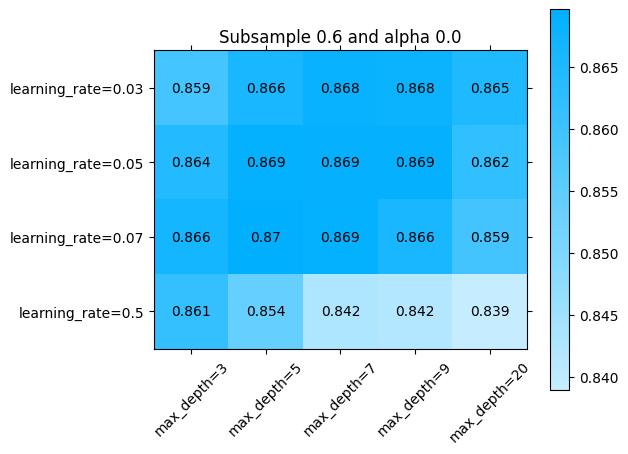

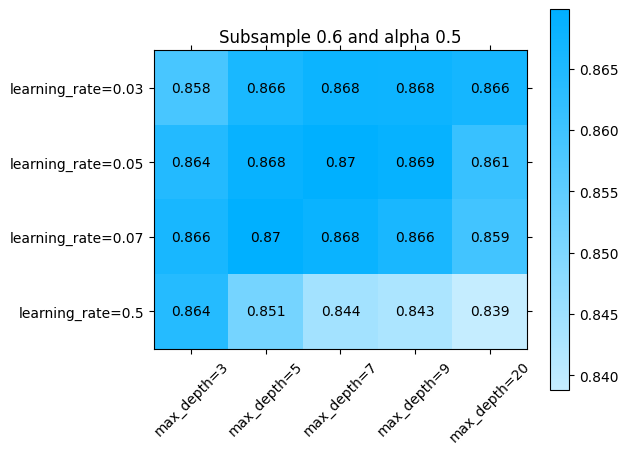

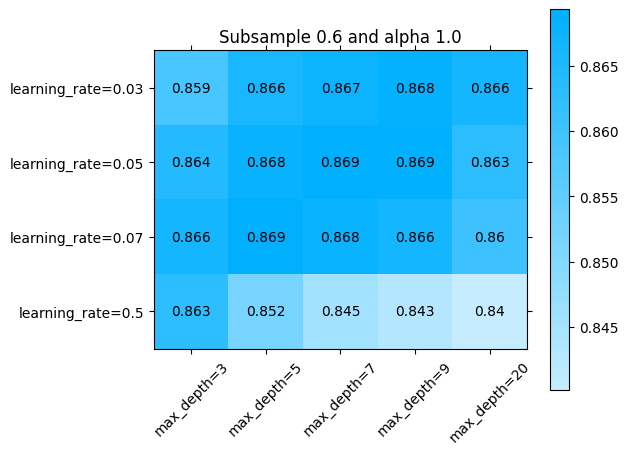

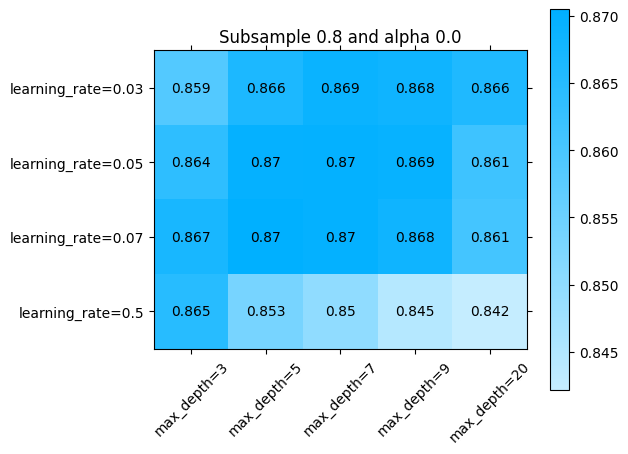

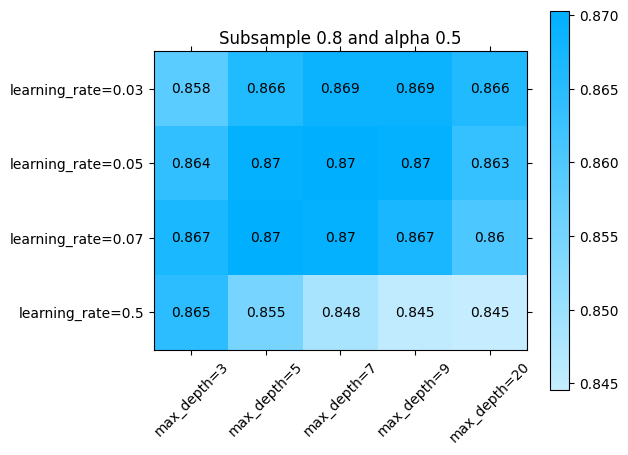

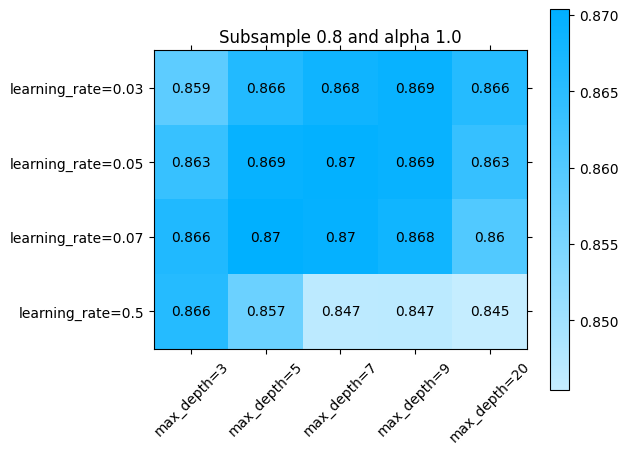

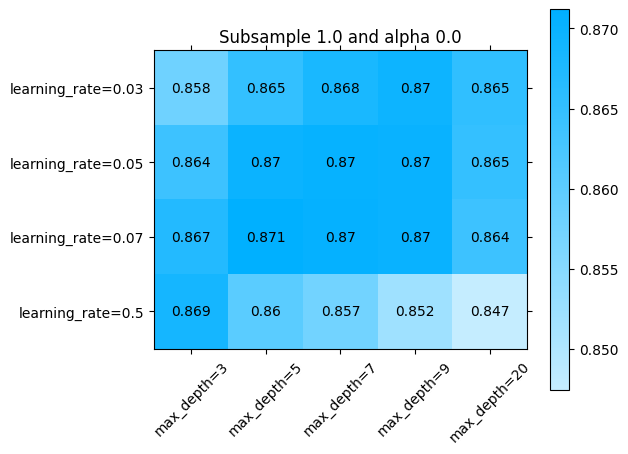

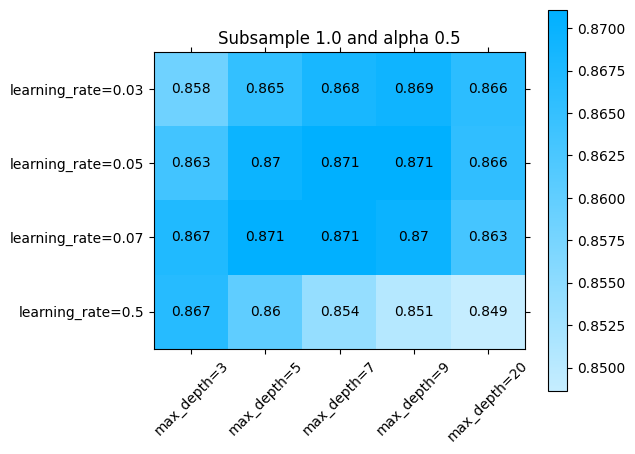

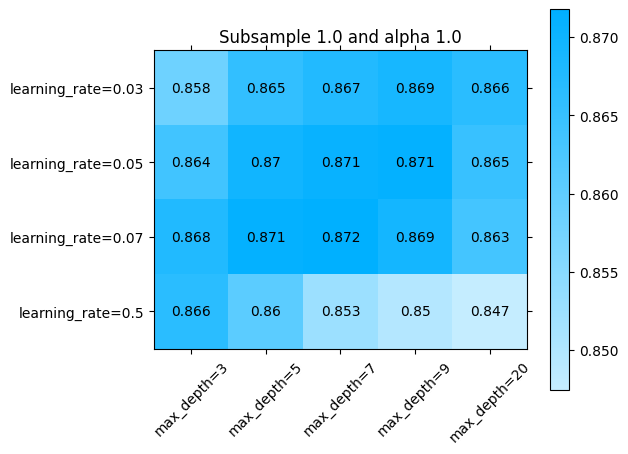

In [51]:
import numpy as np
import matplotlib.pyplot as plt

for idx, (subsample, alpha) in enumerate(np.array(np.meshgrid(parameters['subsample'], parameters['alpha'])).T.reshape(-1,2)):
  fig = plt.figure()
  ax = fig.add_subplot()
  ax.set_title(f"Subsample {subsample} and alpha {alpha}")
  sklearn_evaluation.plot.grid_search(
      best_model.cv_results_,
      change=('learning_rate', 'max_depth'),
      subset={ 'subsample': [subsample], 'alpha': [alpha] },
      ax=ax)
  ax.plot()

### Explorando diferentes combinaciones de hiperparámetros con búsqueda aleatoria

Si bien la búsqueda anterior arroja el mejor resultado posible, es muy costosa computacionalmente. Por ejemplo, en Collaboratory, tardará alrededor de 1 hora en completarse (y se trata de un modelo bastante pequeño).

La búqueda aleatoria permite explorar el espacio sin necesidad de explorar todas las combinaciones posibles. En general generará peor performance, pero mantiene un presupuesto acotado. En este caso, `n_iter` controla la cantidad de modelos que se deben entrenar al muestrar 10 diferentes combinaciones de los parámetros posibles:

In [19]:
from sklearn.model_selection import RandomizedSearchCV

In [26]:
grs = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=parameters,
    cv=2,
    n_iter=10,
    n_jobs=-1,
    verbose=2
)

best_model_random = grs.fit(X_train_transformed, y_train)


Fitting 2 folds for each of 10 candidates, totalling 20 fits
[23:19:35] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



Ejecutamos el modelo

In [27]:
predictions = best_model_random.predict(X_test_transformed)

Podemos revisar la performance del modelo:

In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     12435
           1       0.78      0.65      0.71      3846

    accuracy                           0.87     16281
   macro avg       0.84      0.80      0.81     16281
weighted avg       0.87      0.87      0.87     16281



Podemos inspeccionar cuales son los mejores parametros que se encontraron:

In [29]:
best_model_random.best_params_

{'subsample': 1,
 'n_estimators': 200,
 'min_child_weight': 4,
 'max_depth': 9,
 'learning_rate': 0.05,
 'colsample_bytree': 0.7,
 'alpha': 0}